In [1]:
import sys
import os
import torch
import torch.nn as nn
import numpy.random as random
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

sys.path.append("./")

In [2]:
from autoencode import FFAEEnsemble, standardize
from models import Classifier
from datasets import SupervisedDataset, UnsupervisedDataset

In [3]:
unsup_data = UnsupervisedDataset("/export/gaon1/data/jteneggi/DL/alm")
sup_data = SupervisedDataset("/export/gaon1/data/jteneggi/DL/pedreira")

# spikes, targets = sup_data[0]

# assert len(spikes) == len(targets)
# L = len(spikes)
# idx = list(range(L))

# rng = random.default_rng()
# rng.shuffle(idx)

# train_idx = idx[:int(L/2)]
# val_idx = idx[int(L/2):]

# train_data = (spikes[train_idx], targets[train_idx])
# val_data = (spikes[val_idx], targets[val_idx])

# datasets = {"train": train_data, "val": val_data}
# dataset_sizes = {"train": len(train_idx), "val": len(val_idx)}

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "5"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

ae = FFAEEnsemble(batch_size=1, device=device)
ae.load()

fc = Classifier(num_classes=20, device=device)

Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0
Using cuda:0


In [5]:
unsup_dataloader = DataLoader(unsup_data, batch_size=80, shuffle=True)
sup_dataloader = DataLoader(sup_data, batch_size=2, shuffle=True)

spikes, _ = next(iter(unsup_dataloader))
print(spikes.size())

RuntimeError: stack expects each tensor to be equal size, but got [15, 39] at entry 0 and [39, 39] at entry 1

EPOCH 1 of 50
train classification loss: 4.04941931
train reconstruction losses: [0.04708875418131128, 0.07979517184071369, 0.03933119990460046]
val classification loss: 2.57258908
val reconstruction losses: [0.025718824287285377, 0.03042605817764551, 0.025916386476947075]
EPOCH 2 of 50
train classification loss: 2.82993189
train reconstruction losses: [0.01807226107495797, 0.027038959412898494, 0.024615634419458174]
val classification loss: 2.32578034
val reconstruction losses: [0.014757027383738663, 0.025726338437238296, 0.024624755848577488]
EPOCH 3 of 50
train classification loss: 2.53720448
train reconstruction losses: [0.012686898496127252, 0.023989222806084762, 0.02315587443096456]
val classification loss: 1.89030951
val reconstruction losses: [0.012786943289627145, 0.021811761808666317, 0.02304697860884559]
EPOCH 4 of 50
train classification loss: 2.14930292
train reconstruction losses: [0.01209934576607737, 0.019301378708103282, 0.021972581029032573]
val classification loss: 1

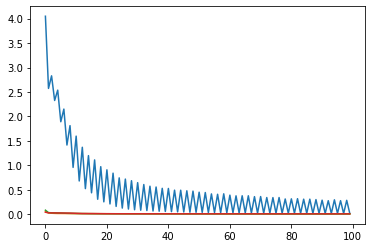

In [5]:
num_epochs = 50
spike_batch_size = 128
lr = 0.001

torch.autograd.set_detect_anomaly(True)

ae_criterion = nn.MSELoss()
class_criterion = nn.CrossEntropyLoss()

params = list(fc.parameters())
for e, d in zip(ae.encoders, ae.decoders):
    params += list(e.parameters()) + list(d.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

class_loss_history = []
ae_losses_history = []

phases = ["train", "val"]
for epoch in range(num_epochs):
    print(f"EPOCH {epoch+1} of {num_epochs}")
    for phase in phases:
        
        if phase=="train":
            map(lambda e: e.train(), ae.encoders)
            map(lambda d: d.train(), ae.decoders)
            fc.train()
        else:
            map(lambda e: e.eval(), ae.encoders)
            map(lambda d: d.eval(), ae.decoders)
            fc.eval()
        
        class_epoch_loss = 0
        ae_epoch_losses = [0 for _ in range(len(ae.encoders))]
        
        spikes, targets = datasets[phase]
        for batch_id in range(ceil(dataset_sizes[phase]/spike_batch_size)):
            spike_batch = spikes[batch_id * spike_batch_size:(batch_id + 1) * spike_batch_size]
            target_batch = targets[batch_id * spike_batch_size:(batch_id + 1) * spike_batch_size]
            
            spike_batch = torch.from_numpy(spike_batch).float().to(device)
            target_batch = torch.from_numpy(target_batch).long().to(device)
            
            optimizer.zero_grad()
            
            latent_vecs = [e(spike_batch) for e in ae.encoders]
            reconstructed = [d(latent_vecs[i]) for i, d in enumerate(ae.decoders)]
            
            ae_losses = [ae_criterion(spike_batch, r) for r in reconstructed]
            for i, l in enumerate(ae_losses):
                ae_epoch_losses[i] += l.detach().cpu().item() * len(spike_batch)
            
            latent = torch.cat(latent_vecs, dim=1)
            
            prediction_batch = fc(latent)
            
            class_loss = class_criterion(prediction_batch, target_batch)
            class_epoch_loss += class_loss.detach().cpu().item() * len(spike_batch)
            
            total_loss = class_loss + sum(ae_losses)
            total_loss.backward()
            optimizer.step()
        
        class_epoch_loss = class_epoch_loss / dataset_sizes[phase]
        ae_epoch_losses = [loss/dataset_sizes[phase] for loss in ae_epoch_losses]
        
        class_loss_history.append(class_epoch_loss)
        ae_losses_history.append(ae_epoch_losses)
        
        print(f"{phase} classification loss: {class_epoch_loss:.8f}")
        # str_ae_losses = [f"{l:.8f}" for l in ae_epoch_losses]
        print(f"{phase} reconstruction losses: {ae_epoch_losses}")

Encoded session 1, 6006 spikes
Learning manifold for latent embeddings


Text(0, 0.5, 'Second dimension')

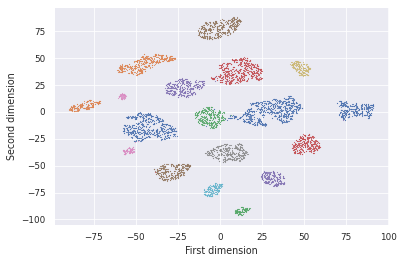

In [13]:
from sklearn.manifold import TSNE
import seaborn as sns

sns.set_theme()
sns.set_context("paper")

tsne = TSNE(n_components=2)

i = 1
spikes, targets = datasets["val"]

spikes = torch.from_numpy(spikes).float().to(device)
latent_vecs = [e(spikes) for e in ae.encoders]
latent = torch.cat(latent_vecs, dim=1).detach().cpu()
print(f"Encoded session {i}, {spikes.size(0)} spikes")
# gt_classes = data.spike_classes[i].squeeze()
print(f"Learning manifold for latent embeddings")
latent_manifold = tsne.fit_transform(latent.cpu())

for c in range(20):
    c_manifold = latent_manifold[targets == c]
    plt.scatter(c_manifold[:, 0], c_manifold[:, 1], marker=".", s=.5)
plt.xlabel("First dimension")
plt.ylabel("Second dimension")